## 一、项目背景

随着国家西电东送战略的提出，特高压输电和高压输电变得尤为重要，输电线路的巡检是保证输电正常的重要一环。智能化电网和的快速发展，巡检无人机、机器人正在逐步代替传统人工巡检。绝缘子是输电线路的重要组成部分，是唯一的电气绝缘件和重要的结构支撑件，绝缘子性能及其配置的合理性直接影响线路的安全稳定运行。绝缘子破损的快速定位排除对保证高压输电线路的正常运行和避免大范围停电具有十分重要的意义。该项目将以高压输电线路上的绝缘子的破损检测为检测对象，利用PaddleDetection进行实现。

![](https://ai-studio-static-online.cdn.bcebos.com/3f2eb65ac05e478bbba5bb93102bf2aa78667d57dbca4f92acd9470ee993a27d)


**PaddleDetection**为基于飞桨PaddlePaddle的端到端目标检测套件，提供多种主流目标检测、实例分割、跟踪、关键点检测算法，配置化的网络模块组件、数据增强策略、损失函数等，推出多种服务器端和移动端工业级SOTA模型，并集成了模型压缩和跨平台高性能部署能力,帮助开发者更快更好完成端到端全开发流程。

**模型丰富:** 包含目标检测、实例分割、人脸检测、关键点检测、多目标跟踪等250+个预训练模型，涵盖多种全球竞赛冠军方案。

**使用简洁：** 模块化设计，解耦各个网络组件，开发者轻松搭建、试用各种检测模型及优化策略，快速得到高性能、定制化的算法。

**端到端打通:** 从数据增强、组网、训练、压缩、部署端到端打通，并完备支持云端/边缘端多架构、多设备部署。

**高性能:**
基于飞桨的高性能内核，模型训练速度及显存占用优势明显。支持FP16训练, 支持多机训练。


## 二、算法
PP-YOLO是PaddleDetection优化和改进的YOLOv3的模型，其精度(COCO数据集mAP)和推理速度均优于YOLOv4模型，要求使用PaddlePaddle 2.0.2(可使用pip安装) 或适当的develop版本。

PP-YOLO在COCO test-dev2017数据集上精度达到45.9%，在单卡V100上FP32推理速度为72.9 FPS, V100上开启TensorRT下FP16推理速度为155.6 FPS。
该项目使用百度自研算法PP-YOLO v2。
![](https://ai-studio-static-online.cdn.bcebos.com/44052a63c217422db66b8a75a4f984f61b7226f246514983a43549f320f85c69)


### 2.1算法介绍
感兴趣的小伙伴可以阅读论文进行详细学习，这里只做重点叙述。

[PP-YOLO](https://arxiv.org/abs/2007.12099)

[PP-YOLOv2](https://arxiv.org/abs/2104.10419)

PP-YOLOv2网络架构
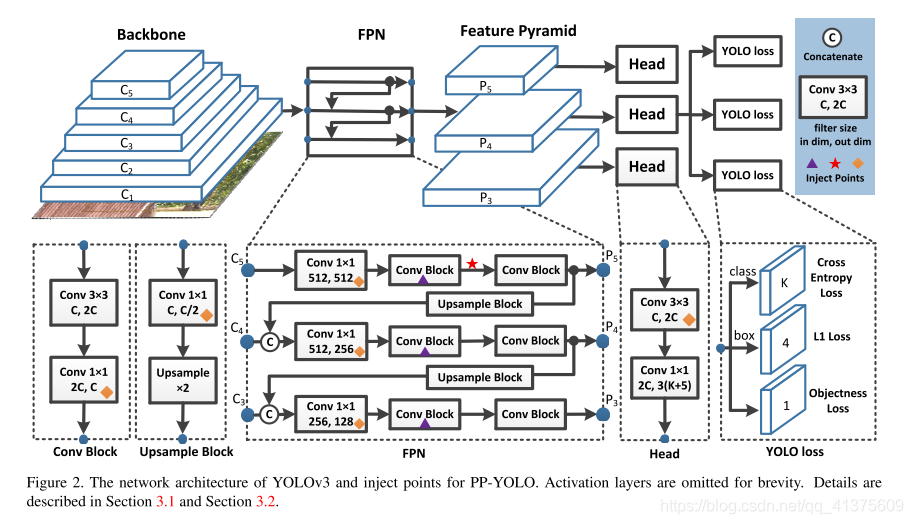

**BackBone骨干网络**

选用ResNet50-vd作为整个架构，并将部分卷积层替换成可变形卷积，适当增加了网络复杂度。由于DCN会带来额外的推理时间，我们仅仅在最后一层的3x3卷积替换成DCN卷积。

**DetectionNeck**

这里依然采取的是FPN特征金字塔结构做一个特征融合，类似Yolo3,我们选取最后三个卷积层C3, C4, C5，然后经过FPN结构，将高层级语义信息和低层级信息进行融合。

**DetectionHead**

原始yolo3的检测头是一个非常简单的结构，通过3x3卷积并最后用1x1卷积调整到自己所需要的通道数目。输出通道数为3(K+5)，3代表每个层设定的三种尺寸的锚框，K代表类别数目，5又可以分成4+1，分别是目标框的4个参数，以及1个参数来判断框里是否有物体*。




PP-YOLOv2，是以 PP-YOLO 为基线模型进行了一系列的延展实验得到的。主要为以下几方面的提升：

**1. 采用 Path Aggregation Network（路径聚合网络）设计 Detection Net**

PP-YOLOv2 第一个优化的尝试是设计一个可以为各种尺度图像构建高层语义特征图的检测颈（detection neck）。不同于 PP-YOLO 采用 FPN 来从下至上的构建特征金字塔，PP-YOLOv2 采用了 FPN 的变形之一—PAN（Path Aggregation Network）来从上至下的聚合特征信息。采用PAN的构成的 detection neck 可以由下图看到。
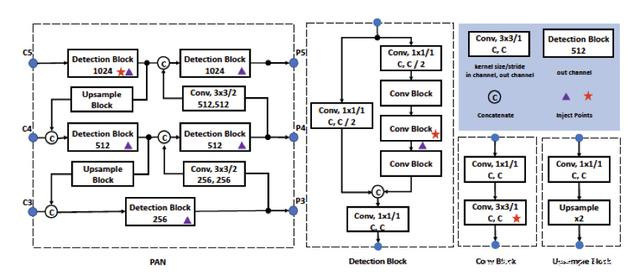

**2.采用 Mish 激活函数**

Mish 激活函数被很多实用的检测器采用，并拥有出色的表现，这里把 mish 激活函数应用在了detection neck而不是骨架网络上。

**3、更大的输入尺寸**

增加输入尺寸直接带来了目标面积的扩大。这样，网络可以更容易捕捉到小尺幅目标的信息，得到更高的性能。然而，更大的输入会带来更多的内存占用。所以在使用这个策略的同时，我们需要同时减少 Batch Size。在具体实验中，我们将 Batch Size 减少了一倍，从每个 GPU 24 张图像减少到每个 GPU 12 张图像，并将最大输入从 608 扩展到 768。输入大小均匀地从 [320, 352, 384, 416, 448, 480, 512, 544, 576, 608, 640, 672, 704, 736, 768] 获取。

**4、IoU Aware Branch**

在 YOLOv3 中，将分类概率和 objectness 相乘作为最终的检测置信度，但却没有考虑定位置信度。为了解决这一问题，我们将 objectness 与定位置信度 IoU 综合起来， 使用下面的公式来计算出一个新的 objectness：

$ s = objectness^{1-a}×p^a $

 p 为检测框与 ground truth 之间的 IoU 的预测值,a为平衡参数，在PP-YOLOv2中设置为 0.5,使用 BCE(binary cross entropy) loss 来学习 p,公式如下：
 
$ loss=-t*log(σ(p))-(1-t)*log(1-σ(p))$

其中 t 为检测框与 ground truth 之间的 IoU，σ（.）代表 sigmoid 激活函数。需要注意的是，只有正性样本的 IoU aware loss 被计算。
通过论文中的消融实验可以看到， PAN、MISH 和输入尺寸的增大都带来了一些计算量的增加，但 mAP 却得到了显著的提升。
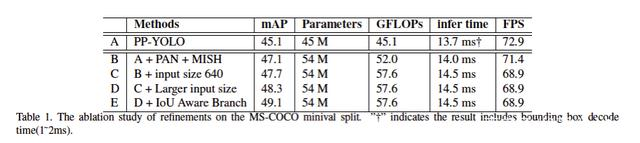

**不管是 PP-YOLO 还是 PP-YOLOv2，都是在寻找在产业实践中最高性价比的目标检测方案，而不是单纯的以提升单阶段目标检测的精度去堆网络和策略。论文中也特别提到，是以实验报告的角度来为业界开发者展示更多网络优化的方法，这些策略也可以被应用在其他网络的优化上，希望在给业界开发者带来更好的网络的同时，也带来更多的算法优化启发。**

### 2.2模型库


[PP-YOLO模型库](https://github.com/PaddlePaddle/PaddleDetection/blob/release/2.4/configs/ppyolo/README_cn.md#%E6%A8%A1%E5%9E%8B%E5%BA%93)
可以根据自己的具体需求进行模型的下载



|          Model           | GPU number | images/GPU |  backbone  | input shape | Box AP<sup>val</sup> | Box AP<sup>test</sup> | V100 FP32(FPS) | V100 TensorRT FP16(FPS) | download | config  |
|:------------------------:|:-------:|:-------------:|:----------:| :-------:| :------------------: | :-------------------: | :------------: | :---------------------: | :------: | :------: |
| PP-YOLO                  |     8      |     24     | ResNet50vd |     608     |         44.8         |         45.2          |      72.9      |          155.6          | [model](https://paddledet.bj.bcebos.com/models/ppyolo_r50vd_dcn_1x_coco.pdparams) | [config](https://github.com/PaddlePaddle/PaddleDetection/tree/release/2.0/configs/ppyolo/ppyolo_r50vd_dcn_1x_coco.yml)                   |
| PP-YOLO                  |     8      |     24     | ResNet50vd |     512     |         43.9         |         44.4          |      89.9      |          188.4          | [model](https://paddledet.bj.bcebos.com/models/ppyolo_r50vd_dcn_1x_coco.pdparams) | [config](https://github.com/PaddlePaddle/PaddleDetection/tree/release/2.0/configs/ppyolo/ppyolo_r50vd_dcn_1x_coco.yml)                   |
| PP-YOLO                  |     8      |     24     | ResNet50vd |     416     |         42.1         |         42.5          |      109.1      |          215.4          | [model](https://paddledet.bj.bcebos.com/models/ppyolo_r50vd_dcn_1x_coco.pdparams) | [config](https://github.com/PaddlePaddle/PaddleDetection/tree/release/2.0/configs/ppyolo/ppyolo_r50vd_dcn_1x_coco.yml)                   |
| PP-YOLO                  |     8      |     24     | ResNet50vd |     320     |         38.9         |         39.3          |      132.2      |          242.2          | [model](https://paddledet.bj.bcebos.com/models/ppyolo_r50vd_dcn_1x_coco.pdparams) | [config](https://github.com/PaddlePaddle/PaddleDetection/tree/release/2.0/configs/ppyolo/ppyolo_r50vd_dcn_1x_coco.yml)                   |
| PP-YOLO_2x               |     8      |     24     | ResNet50vd |     608     |         45.3         |         45.9          |      72.9      |          155.6          | [model](https://paddledet.bj.bcebos.com/models/ppyolo_r50vd_dcn_2x_coco.pdparams) | [config](https://github.com/PaddlePaddle/PaddleDetection/tree/release/2.0/configs/ppyolo/ppyolo_r50vd_dcn_2x_coco.yml)                   |
| PP-YOLO_2x               |     8      |     24     | ResNet50vd |     512     |         44.4         |         45.0          |      89.9      |          188.4          | [model](https://paddledet.bj.bcebos.com/models/ppyolo_r50vd_dcn_2x_coco.pdparams) | [config](https://github.com/PaddlePaddle/PaddleDetection/tree/release/2.0/configs/ppyolo/ppyolo_r50vd_dcn_2x_coco.yml)                   |
| PP-YOLO_2x               |     8      |     24     | ResNet50vd |     416     |         42.7         |         43.2          |      109.1      |          215.4          | [model](https://paddledet.bj.bcebos.com/models/ppyolo_r50vd_dcn_2x_coco.pdparams) | [config](https://github.com/PaddlePaddle/PaddleDetection/tree/release/2.0/configs/ppyolo/ppyolo_r50vd_dcn_2x_coco.yml)                   |
| PP-YOLO_2x               |     8      |     24     | ResNet50vd |     320     |         39.5         |         40.1          |      132.2      |          242.2          | [model](https://paddledet.bj.bcebos.com/models/ppyolo_r50vd_dcn_2x_coco.pdparams) | [config](https://github.com/PaddlePaddle/PaddleDetection/tree/release/2.0/configs/ppyolo/ppyolo_r50vd_dcn_2x_coco.yml)                   |
| PP-YOLO               |     4      |     32     | ResNet18vd |     512     |         29.2         |         29.5          |      357.1      |          657.9          | [model](https://paddledet.bj.bcebos.com/models/ppyolo_r18vd_coco.pdparams) | [config](https://github.com/PaddlePaddle/PaddleDetection/tree/release/2.0/configs/ppyolo/ppyolo_r18vd_coco.yml)                   |
| PP-YOLO               |     4      |     32     | ResNet18vd |     416     |         28.6         |         28.9          |      409.8      |          719.4          | [model](https://paddledet.bj.bcebos.com/models/ppyolo_r18vd_coco.pdparams) | [config](https://github.com/PaddlePaddle/PaddleDetection/tree/release/2.0/configs/ppyolo/ppyolo_r18vd_coco.yml)                   |
| PP-YOLO               |     4      |     32     | ResNet18vd |     320     |         26.2         |         26.4          |      480.7      |          763.4          | [model](https://paddledet.bj.bcebos.com/models/ppyolo_r18vd_coco.pdparams) | [config](https://github.com/PaddlePaddle/PaddleDetection/tree/release/2.0/configs/ppyolo/ppyolo_r18vd_coco.yml)                   |
| PP-YOLOv2               |     8      |     12     | ResNet50vd |     640     |         49.1         |         49.5          |      68.9      |          106.5          | [model](https://paddledet.bj.bcebos.com/models/ppyolov2_r50vd_dcn_365e_coco.pdparams) | [config](https://github.com/PaddlePaddle/PaddleDetection/tree/release/2.0/configs/ppyolo/ppyolov2_r50vd_dcn_365e_coco.yml)                   |
| PP-YOLOv2               |     8      |     12     | ResNet101vd |     640     |         49.7         |         50.3          |     49.5     |         87.0         | [model](https://paddledet.bj.bcebos.com/models/ppyolov2_r101vd_dcn_365e_coco.pdparams) | [config](https://github.com/PaddlePaddle/PaddleDetection/tree/release/2.0/configs/ppyolo/ppyolov2_r101vd_dcn_365e_coco.yml)                   |




## 三、项目内容
该项目使用PaddleDetection套件，项目内容主要包括环境的配置，数据的准备，配置文件的修改，模型训练，模型评估，模型推理测试，模型导出等

### 3.1环境配置

In [ ]:
%cd work/
# 下载PaddleDetection，fork完项目之后，只需要执行一次该命令即可，不需要每次都git
#!git clone https://github.com/PaddlePaddle/PaddleDetection.git

In [1]:
#安装PaddleDetection依赖
!pip install -r /home/aistudio/work/PaddleDetection/requirements.txt

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 11.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.6/106.6 KB 22.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 10.0 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.1/161.1 KB 15.8 MB/s eta 0:00:00
  Created wheel for pycocotools: filename=pycocotools-2.0.4-cp37-cp37m-linux_x86_64.whl size=273775 sha256=05892e169214dc4645ae0bb4576fd9f8e8068a7e1aaae6b35b1452dd7cd9d74a
  Stored in directory: /home/aistudio/.cache/pip/wheels/c0/01/5f/670dfd20204fc9cc6bf843db4e014acb998f411922e3abc49f
  Created wheel for lap: filename=lap-0.4.0-cp37-cp37m-linux_x86_64.whl size=1593901 sha256=253f4f78308656c4c0186d84c525600e14630345651e

In [8]:
#编译安装paddledet
%cd work/PaddleDetection
!python setup.py install


running install
running bdist_egg
running egg_info
writing paddledet.egg-info/PKG-INFO
writing dependency_links to paddledet.egg-info/dependency_links.txt
writing requirements to paddledet.egg-info/requires.txt
writing top-level names to paddledet.egg-info/top_level.txt
adding license file 'LICENSE' (matched pattern 'LICEN[CS]E*')
reading manifest file 'paddledet.egg-info/SOURCES.txt'
writing manifest file 'paddledet.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
copying ppdet/version.py -> build/lib/ppdet
copying ppdet/model_zoo/MODEL_ZOO -> build/lib/ppdet/model_zoo
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/ppdet
copying build/lib/ppdet/version.py -> build/bdist.linux-x86_64/egg/ppdet
creating build/bdist.linux-x86_64/egg/ppdet/modeling
creating build/bdist.linux-x86_64/egg/ppdet/modeling/architectures
copying build/lib/ppdet/modeling/architectures/tood.py -> build/bdist.linux-x86_64

In [9]:
#测试安装是否成功，最后输出OK，说明编译安装成功
!python ppdet/modeling/tests/test_architectures.py

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/tensor/creation.py:130: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if data.dtype == np.object:
W0425 08:34:50.913024  1025 device_context.cc:447] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 10.1, Runtime API Version: 10.1
W0425 08:34:50.918601  1025 device_context.cc:465] device: 0, cuDNN Version: 7.6.
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/tensor/creation.py:130: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and g

### 3.2准备数据集

由于相关的数据集较少，原图片大多是从不同图片网站上下载，然后对图片进行相应的数据处理或者p图得到(辛苦P了半个月，保证尽可能地还原自然场景下真实情况)，里面包括600张高压输电线路缺损的绝缘子图片，使用Imgme进行标注，生成voc格式数据集。

[数据集链接](https://aistudio.baidu.com/aistudio/datasetdetail/122549)

[如何准备训练数据](https://github.com/PaddlePaddle/PaddleDetection/blob/release/2.4/docs/tutorials/PrepareDataSet.md#%E5%A6%82%E4%BD%95%E5%87%86%E5%A4%87%E8%AE%AD%E7%BB%83%E6%95%B0%E6%8D%AE)


注意：下面这段代码，只需要运行一次即可，如果PaddleDetection路径下已经存在insulator文件夹，不需要重复执行解压数据集和划分数据集两步


In [17]:
#解压数据集
!unzip -oq /home/aistudio/data/data122549/insulator.zip -d /home/aistudio/work/PaddleDetection

#划分数据集
#根据挂载的数据集制作制作标签文件，并进行划分
import random
import os
#生成train.txt和val.txt
random.seed(2020)
xml_dir  = '/home/aistudio/work/PaddleDetection/insulator/Annotations'#标签文件地址
img_dir = '/home/aistudio/work/PaddleDetection/insulator/JPEGImages'#图像文件地址
path_list = list()
for img in os.listdir(img_dir):
    img_path = os.path.join(img_dir,img)
    xml_path = os.path.join(xml_dir,img.replace('jpg', 'xml'))
    path_list.append((img_path, xml_path))
random.shuffle(path_list)
ratio = 0.9
train_f = open('/home/aistudio/work/PaddleDetection/insulator/train.txt','w') #生成训练文件
val_f = open('/home/aistudio/work/PaddleDetection/insulator/val.txt' ,'w')#生成验证文件

for i ,content in enumerate(path_list):
    img, xml = content
    text = img + ' ' + xml + '\n'
    if i < len(path_list) * ratio:
        train_f.write(text)
    else:
        val_f.write(text)
train_f.close()
val_f.close()

#生成标签文档
label = ['insulator']#设置你想检测的类别
with open('/home/aistudio/work/PaddleDetection/insulator/label_list.txt', 'w') as f:
    for text in label:
        f.write(text+'\n')

最终生成的数据集文件夹目录为

![](https://ai-studio-static-online.cdn.bcebos.com/becce959f7524de281ab8ec0a5bd89a850726af82b0b43aa9058ba05f47ed90f)


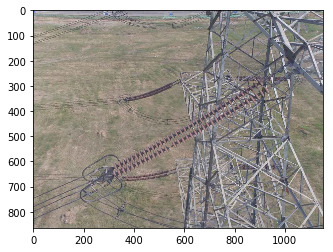

In [19]:
#随机查看文字检测数据集图片，如果运行一次没有显示图片，再运行一次即可
from PIL import Image  
import matplotlib.pyplot as plt
import numpy as np
import os 

    
train = '/home/aistudio/work/PaddleDetection/insulator/JPEGImages' 
#从指定目录中选取一张图片 
def get_one_image(train): 
   
    #image_array = get_one_image(train)  
    plt.figure() 
    files = os.listdir(train)
    n = len(files)
    ind = np.random.randint(0,n)
    img_dir = os.path.join(train,files[ind])  
    image = Image.open(img_dir)  
    plt.imshow(image)
    plt.show()
    image = image.resize([508, 508])  
    
  
get_one_image(train)  


### 3.3修改配置文件

找到我们训练需要的配置文件，以ppyolov2其中一个的配置文件为例，configs/ppyolo/ppyolov2_r50vd_dcn_voc.yml

打开之后可以看到我们依赖的配置文件

![](https://ai-studio-static-online.cdn.bcebos.com/c222e43822634ab893ff70dee620022cf0b5356d36524ee8b24df913cf80a943)




然后根据实际的需求进行修改
1. ../datasets/voc.yml 主要说明了训练数据和验证数据的路径。例如：数据集格式，分类数和训练集路径、验证集路径等。
1. ../runtime.yml主要说明了公共的运行参数。例如：是否使用GPU，模型保存路径等。
1. ./_base_/ppyolov2_r50vd_dcn.yml 主要说明模型、和主干网络的情况。例如backbone，neck，head，loss，前后处理等。
1. ../_base_/optimizer_365e.yml 主要说明了学习率和优化器的配置。例如学习率和学习率策略，优化器类型等。 
1. ./_base_/ppyolov2_reader.yml 主要说明数据读取器配置。例如batch size，并发加载子进程数，数据预处理等。

新版的PaddleDetection，可以对配置文件集中修改，不需要每个配置文件都挨个进行更改。后续调优过程中可以去每个配置文件再进行具体调整。
所以只需要修改配置文件configs/ppyolo/ppyolov2_r50vd_dcn_voc.yml和和配置文件../datasets/voc.yml，具体修改内容如图框中部分所示，这里开发者们可以根据自己的调优策略进行修改，本项目只作参考。
![](https://ai-studio-static-online.cdn.bcebos.com/90461cb3a36f488fbee9625d066f80139429a51fbf6a4cd8ad8997fbf15a9b99)



![](https://ai-studio-static-online.cdn.bcebos.com/0ba8f260fb2b44dca99bfd305a87d294ea61978f28514014ae2e8a1690151c39)







### 3.4开始训练

**--eval** 代表边训练边评估，每次评估后还会评出最佳mAP模型保存到best_model文件夹下，如果验证集很大，测试将会比较耗时，建议调整configs/runtime.yml 文件中的 snapshot_epoch配置以减少评估次数，或训练完成后再进行评估。

**--use_vdl=True**  开启可视化


**--vdl_log_dir="./output"** 将生成的日志放在output文件夹下

anchors是可以事先通过cmd指令计算出来的，是和图片数量，width,height以及cluster相关的预选框，可以手工挑选，也可以用    k-means算法从训练样本中学出。而原始默认配置中大多针对大目标，而在这里绝缘子在图片中的尺寸较小。为提升检测精度，在训练之前使用tools/anchor_cluster.py得到适用于你的数据集的anchor尺寸：

[13,12],[17,13],[15,16],[19,16],[18,20],[21,18],[19,24],[22,21],[24,26]

并注意修改相关配置文件中的anchor设置，如/home/aistudio/work/PaddleDetection/configs/ppyolo/_base_/ppyolo_reader.yml
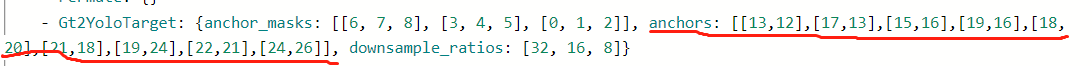

如/home/aistudio/work/PaddleDetection/configs/ppyolo/_base_/ppyolov2_r50vd_dcn.yml
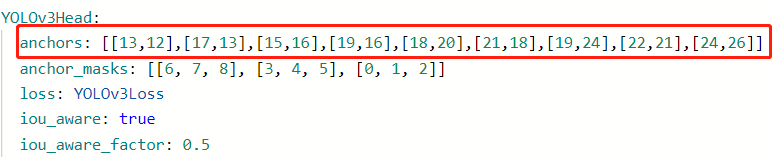

**注意：**如果效果不好的话，还是建议使用默认配置中的anchor尺寸

In [24]:
!python tools/anchor_cluster.py -c configs/ppyolo/ppyolov2_r50vd_dcn_voc.yml -n 9 -s 320 -m v2 -i 1000

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/tensor/creation.py:130: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if data.dtype == np.object:
100%|██████████████████████████████████████| 540/540 [00:00<00:00, 40925.21it/s]
[04/25 10:11:42] ppdet.anchor_cluster INFO: Running kmeans for 9 anchors on 542 points...
avg_iou: 0.8990:   0%|                                 | 0/1000 [00:00<?, ?it/s]
[04/25 10:11:42] ppdet.anchor_cluster INFO: 9 anchor cluster result: [w, h]
[04/25 10:11:42] ppdet.anchor_cluster INFO: [13, 12]
[04/25 10:11:42] ppdet.anchor_cluster INFO: [17, 13]
[04/25 10:11:42] ppdet.anchor_cluster INFO: [15, 16]
[04/25 10:11:42] ppdet.anchor_cluster INFO: [19, 16]
[04/25 10:11:42] ppdet.anch

In [28]:
#开启训练
!python tools/train.py -c configs/ppyolo/ppyolov2_r50vd_dcn_voc.yml --eval --use_vdl=True --vdl_log_dir="./output"

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/tensor/creation.py:130: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if data.dtype == np.object:
W0425 14:02:20.895833 32044 device_context.cc:447] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 10.1, Runtime API Version: 10.1
W0425 14:02:20.901192 32044 device_context.cc:465] device: 0, cuDNN Version: 7.6.
[04/25 14:02:25] ppdet.utils.checkpoint INFO: Finish loading model weights: /home/aistudio/.cache/paddle/weights/ResNet50_vd_ssld_pretrained.pdparams
[04/25 14:02:26] ppdet.engine INFO: Epoch: [0] [ 0/45] learning_rate: 0.000000 loss_xy: 1.122523 loss_wh: 2.659291 loss_iou: 3.835977 loss_iou_aware: 0.745107 loss_obj: 30588.4414

In [ ]:
#如果中间训练中断，可以进行断点训练
!python tools/train.py -c configs/ppyolo/ppyolov2_r50vd_dcn_voc.yml -r /output/ppyolov2_r50vd_dcn_voc/10000

### 3.5训练可视化

当打开use_vdl开关后，为了方便用户实时查看训练过程中状态，PaddleDetection集成了VisualDL可视化工具，当打开use_vdl开关后，记录的数据包括：

loss变化趋势

mAP变化趋势

![](https://ai-studio-static-online.cdn.bcebos.com/67db552b0a0b4f3f8e3bd041b979f3cad3846b07b9e546b0a4d56c751c73c782)

选择训练时生成的logdir或者模型文件，启动VisualDL服务，即可查看，可以根据训练曲线，进行模型调优
选择output文件夹

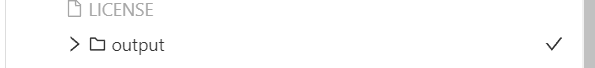

然后启动服务后可以看到训练曲线，我们重点关注bbox-mAP和loss，然后根据曲线情况进行调整或者提前终止训练。

![](https://ai-studio-static-online.cdn.bcebos.com/84467e4068e0480fae2974dbd5bbf06a21e15085519c4bdfb14b43b9bb802579)
![](https://ai-studio-static-online.cdn.bcebos.com/bcbcd4b1ef4e48b1af9d438811372d8cd9fed31725b44ee1832c6dd2de7c2fee)



### 3.6模型评估
由于我们边训练边评估，已经保存好了最优模型，所以在这里可以不进行评估，最优模型文件如下图所示
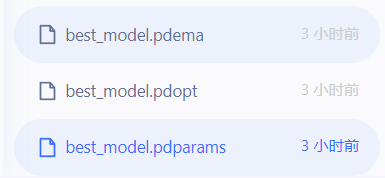

**.pdmodel**
是训练使用的完整模型program描述，区别于推理模型，训练模型program包含完整的网络，包括前向网络，反向网络和优化器，而推理模型program仅包含前向网络。

**.pdparams**
是训练网络的参数dict，key为变量名，value为Tensor array数值

***.pdopt**是训练优化器的参数，结构与*.pdparams一致。

In [29]:
#评估模型
!python -u tools/eval.py -c configs/ppyolo/ppyolov2_r50vd_dcn_voc.yml  \
-o weights=/home/aistudio/work/PaddleDetection/output/ppyolov2_r50vd_dcn_voc/best_model.pdparams

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/tensor/creation.py:130: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if data.dtype == np.object:
W0425 20:01:28.632746  4260 device_context.cc:447] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 10.1, Runtime API Version: 10.1
W0425 20:01:28.638494  4260 device_context.cc:465] device: 0, cuDNN Version: 7.6.
[04/25 20:01:33] ppdet.utils.checkpoint INFO: Finish loading model weights: /home/aistudio/work/PaddleDetection/output/ppyolov2_r50vd_dcn_voc/best_model.pdparams
[04/25 20:01:34] ppdet.engine INFO: Eval iter: 0
[04/25 20:01:35] ppdet.metrics.metrics INFO: Accumulating evaluatation results...
[04/25 20:01:35] ppdet.metrics.metri

### 3.7模型测试
使用训练好的模型进行测试，读者可以选择验证集中的其他图片进行测试。

In [30]:
#使用图片进行推理测试，这里亦可以通过-c直接指定一些参数
!python tools/infer.py -c configs/ppyolo/ppyolov2_r50vd_dcn_voc.yml \
  -o weights=/home/aistudio/work/PaddleDetection/output/ppyolov2_r50vd_dcn_voc/best_model.pdparams \
  --infer_img=/home/aistudio/work/PaddleDetection/insulator/JPEGImages/1816.jpg
  #也可以通过--infer_dir指定目录并推理目录下所有图像

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/tensor/creation.py:130: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if data.dtype == np.object:
W0425 20:02:09.198675  4400 device_context.cc:447] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 10.1, Runtime API Version: 10.1
W0425 20:02:09.204820  4400 device_context.cc:465] device: 0, cuDNN Version: 7.6.
[04/25 20:02:13] ppdet.utils.checkpoint INFO: Finish loading model weights: /home/aistudio/work/PaddleDetection/output/ppyolov2_r50vd_dcn_voc/best_model.pdparams
100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.61it/s]
[04/25 20:02:13] ppdet.engine INFO: Detection bbox results save in output/1816.jpg


In [ ]:
#对测试结果图片进行可视化

#显示结果
import matplotlib.pyplot as plt
from PIL import Image
## 显示原图
img_path= "/home/aistudio/work/PaddleDetection/output/1816.jpg"
img = Image.open(img_path)
plt.figure("test_img", figsize=(100,100))
plt.imshow(img)
plt.show()

测试结果
![](https://ai-studio-static-online.cdn.bcebos.com/cc1e672441be49dabbf19b74e31d1e691205827246894896ba05a3e94c49e195)



**注意：**这里我把训练好的模型复制到了work文件夹下，不想训练的话可以直接使用我训练好的模型进行测试

In [33]:
!python tools/infer.py -c configs/ppyolo/ppyolov2_r50vd_dcn_voc.yml \
  -o weights=/home/aistudio/work/output/ppyolov2_r50vd_dcn_voc/best_model.pdparams \
  --infer_img=/home/aistudio/work/PaddleDetection/insulator/JPEGImages/1816.jpg

### 3.8模型导出

在模型训练过程中保存的模型文件是包含前向预测和反向传播的过程，在实际的工业部署则不需要反向传播，因此需要将模型进行导成部署需要的模型格式。 在PaddleDetection中提供了 tools/export_model.py脚本来导出模型,方便后面的模型部署。

导出的推理模型文件结构如下图所示：

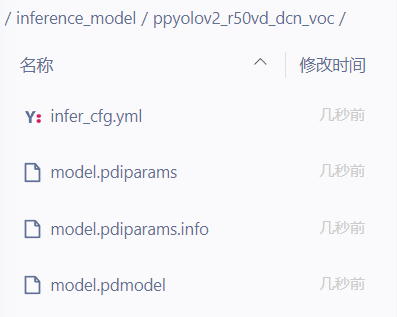

In [35]:
!python tools/export_model.py -c configs/yolov3/yolov3_mobilenet_v1_roadsign.yml --output_dir=./inference_model \
 -o weights=output/yolov3_mobilenet_v1_roadsign/best_model

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/tensor/creation.py:130: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if data.dtype == np.object:
[04/25 20:17:50] ppdet.utils.checkpoint INFO: Finish loading model weights: /home/aistudio/work/output/ppyolov2_r50vd_dcn_voc/best_model.pdparams
[04/25 20:17:50] ppdet.engine INFO: Export inference config file to ./inference_model/ppyolov2_r50vd_dcn_voc/infer_cfg.yml
W0425 20:17:55.399611  5505 device_context.cc:447] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 10.1, Runtime API Version: 10.1
W0425 20:17:55.399683  5505 device_context.cc:465] device: 0, cuDNN Version: 7.6.
[04/25 20:18:01] ppdet.engine INFO: Export model and saved i

**注意：**如果在使用过程中出现找不到文件的错误，建议通过cd切换路径，或者干脆直接使用绝对路径。